# DeblurGAN:  Deblurring Using Conditional Adversarial Networks



# Dependencies

In [2]:
import random
import cv2
import tqdm
import numpy as np
import tensorflow as tf
import keras.backend as K
import os
import matplotlib.pyplot as plt

%matplotlib inline

from PIL import Image, ImageEnhance

from keras.backend.common import normalize_data_format
from keras.engine import InputSpec
from keras.engine.topology import Layer
from keras.utils import conv_utils
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.layers import Input, Activation, Add, UpSampling2D, BatchNormalization, Conv2D, Dense, Flatten, Lambda
from keras.layers.merge import Add
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


# Model Architecture

In [3]:
channel_rate = 64
image_shape = (256, 256, 3)
patch_shape = (channel_rate, channel_rate, 3)
RESHAPE = (256, 256)
ngf = 64
ndf = 64
input_nc = 3
output_nc = 3
input_shape_generator = (256, 256, input_nc)
input_shape_discriminator = (256, 256, output_nc)
n_blocks_gen = 9

In [4]:
def spatial_reflection_2d_padding(x, padding=((1, 1), (1, 1)), data_format=None):
    if data_format is None:
        data_format = image_data_format()
    
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format ' + str(data_format))

    if data_format == 'channels_first':
        pattern = [[0, 0],[0, 0],list(padding[0]),list(padding[1])]
    else:
        pattern = [[0, 0],list(padding[0]), list(padding[1]),[0, 0]]
    return tf.pad(x, pattern, "REFLECT")

In [5]:
class ReflectionPadding2D(Layer):

    def __init__(self,padding=(1, 1),data_format=None,**kwargs):
        super(ReflectionPadding2D, self).__init__(**kwargs)
        self.data_format = normalize_data_format(data_format)
        if isinstance(padding, int):
            self.padding = ((padding, padding), (padding, padding))
        elif hasattr(padding, '__len__'):
            if len(padding) != 2:
                raise ValueError('`padding` should have two elements. ''Found: ' + str(padding))
            height_padding = conv_utils.normalize_tuple(padding[0], 2,'1st entry of padding')
            width_padding = conv_utils.normalize_tuple(padding[1], 2,'2nd entry of padding')
            self.padding = (height_padding, width_padding)
        else:
            raise ValueError('`padding` should be either an int, ''a tuple of 2 ints ''(symmetric_height_pad, symmetric_width_pad), ''or a tuple of 2 tuples of 2 ints ''((top_pad, bottom_pad), (left_pad, right_pad)). ''Found: ' + str(padding))
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            if input_shape[2] is not None:
                rows = input_shape[2] + self.padding[0][0] + self.padding[0][1]
            else:
                rows = None
            if input_shape[3] is not None:
                cols = input_shape[3] + self.padding[1][0] + self.padding[1][1]
            else:
                cols = None
            return (input_shape[0],input_shape[1],rows,cols)
        elif self.data_format == 'channels_last':
            if input_shape[1] is not None:
                rows = input_shape[1] + self.padding[0][0] + self.padding[0][1]
            else:
                rows = None
            if input_shape[2] is not None:
                cols = input_shape[2] + self.padding[1][0] + self.padding[1][1]
            else:
                cols = None
            return (input_shape[0],rows,cols,input_shape[3])

    def call(self, inputs):
        return spatial_reflection_2d_padding(inputs,padding=self.padding,data_format=self.data_format)

    def get_config(self):
        config = {'padding': self.padding,'data_format': self.data_format}
        base_config = super(ReflectionPadding2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [6]:
def res_block(input, filters, kernel_size=(3, 3), strides=(1, 1), use_dropout=False):
    block = ReflectionPadding2D((1, 1))(input)
    block = Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,)(block)
    block = BatchNormalization()(block)
    block = Activation('relu')(block)

    if use_dropout:
        block = Dropout(0.5)(block)

    block = ReflectionPadding2D((1, 1))(block)
    block = Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,)(block)
    block = BatchNormalization()(block)

    merged = Add()([input, block])
    return merged

In [7]:
def generator_model():
    """Build generator architecture."""

    inputs = Input(shape=image_shape)

    x = ReflectionPadding2D((3, 3))(inputs)
    x = Conv2D(filters=ngf, kernel_size=(7, 7), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    n_downsampling = 2
    for i in range(n_downsampling):
        mult = 2**i
        x = Conv2D(filters=ngf*mult*2, kernel_size=(3, 3), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    mult = 2**n_downsampling
    for i in range(n_blocks_gen):
        x = res_block(x, ngf*mult, use_dropout=True)

    for i in range(n_downsampling):
        mult = 2**(n_downsampling - i)
        x = UpSampling2D()(x)
        x = Conv2D(filters=int(ngf * mult / 2), kernel_size=(3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    x = ReflectionPadding2D((3, 3))(x)
    x = Conv2D(filters=output_nc, kernel_size=(7, 7), padding='valid')(x)
    x = Activation('tanh')(x)

    outputs = Add()([x, inputs])
    outputs = Lambda(lambda z: z/2)(outputs)

    model = Model(inputs=inputs, outputs=outputs, name='Generator')
    return model

In [8]:
def discriminator_model():
    """Build discriminator architecture."""
    
    n_layers, use_sigmoid = 3, False
    inputs = Input(shape=input_shape_discriminator)

    x = Conv2D(filters=ndf, kernel_size=(4, 4), strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)

    nf_mult, nf_mult_prev = 1, 1
    for n in range(n_layers):
        nf_mult_prev, nf_mult = nf_mult, min(2**n, 8)
        x = Conv2D(filters=ndf*nf_mult, kernel_size=(4, 4), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

    nf_mult_prev, nf_mult = nf_mult, min(2**n_layers, 8)
    x = Conv2D(filters=ndf*nf_mult, kernel_size=(4, 4), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(filters=1, kernel_size=(4, 4), strides=1, padding='same')(x)
    if use_sigmoid:
        x = Activation('sigmoid')(x)

    x = Flatten()(x)
    x = Dense(1024, activation='tanh')(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=x, name='Discriminator')
    return model


In [9]:
def generator_containing_discriminator(generator, discriminator):
    inputs = Input(shape=image_shape)
    generated_image = generator(inputs)
    outputs = discriminator(generated_image)
    model = Model(inputs=inputs, outputs=outputs)
    return model

def generator_containing_discriminator_multiple_outputs(generator, discriminator):
    inputs = Input(shape=image_shape)
    generated_image = generator(inputs)
    outputs = discriminator(generated_image)
    model = Model(inputs=inputs, outputs=[generated_image, outputs])
    return model

In [10]:
# Defining losses as mentioned in the paper

def perceptual_loss(y_true, y_pred):
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=image_shape)
    loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
    loss_model.trainable = False
    return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))


def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

# Utility Functions

In [11]:
def list_npy_files(directory):
    files = sorted(os.listdir(directory))
    return files
    

def load_npy(path):
    image = Image.open(path)
    image_np = np.array(image)
    image_np = np.stack((image_np,) * 3, axis=-1)
    return image_np


def preprocess_npy(npy):
    npy = (npy - 127.5) / 127.5
    return npy

In [12]:
def load_npys(path, n_npy):
    if n_npy < 0:
        n_npy = float("inf")
    A_paths, B_paths = os.path.join(path, 'A'), os.path.join(path, 'B')
    all_A_paths, all_B_paths = list_npy_files(A_paths), list_npy_files(B_paths)
    
    zipped_lists = list(zip(all_A_paths, all_B_paths))
    random.shuffle(zipped_lists)

    all_A_paths, all_B_paths = zip(*zipped_lists)

    npy_A, npy_B = [], []
    npy_A_paths, npy_B_paths = [], []
    for path_A, path_B in zip(all_A_paths, all_B_paths):
        np_A, np_B = load_npy('./data/A/'+path_A), load_npy('./data/B/'+path_B)
        npy_A.append(preprocess_npy(np_A))
        npy_B.append(preprocess_npy(np_B))
        npy_A_paths.append(path_A)
        npy_B_paths.append(path_B)
        if len(npy_A) > n_npy - 1:
            break

    return {
        'A': np.array(npy_A),
        'A_paths': np.array(npy_A_paths),
        'B': np.array(npy_B),
        'B_paths': np.array(npy_B_paths)
    }

In [13]:
def deprocess_image(img):
    img = img * 127.5 + 127.5
    return img.astype('uint8')


def save_image(np_arr, path):
    img = np_arr * 127.5 + 127.5
    im = Image.fromarray(img)
    im.save(path)


def save_all_weights(d, g, epoch_number, current_loss):
    g.save(os.path.join('./weights/', 'generator_{}_{}.h5'.format(epoch_number+100, current_loss)))
    d.save(os.path.join('./weights/', 'discriminator_{}.h5'.format(epoch_number+100)))

def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

# Training

In [14]:
def train_multiple_outputs(n_images, batch_size, epoch_num, critic_updates=5, train=False):
    if train==True:
        data = load_npys('./data/', n_images)
        y_train, x_train = data['B'], data['A']

    g = generator_model()
    d = discriminator_model()
    d_on_g = generator_containing_discriminator_multiple_outputs(g, d)

    d_opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    d_on_g_opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    d.trainable = True
    d.compile(optimizer=d_opt, loss=wasserstein_loss)
    d.trainable = False
    loss = [perceptual_loss, wasserstein_loss]
    loss_weights = [100, 1]
    d_on_g.compile(optimizer=d_on_g_opt, loss=loss, loss_weights=loss_weights)
    d.trainable = True

    output_true_batch, output_false_batch = np.ones((batch_size, 1)), -np.ones((batch_size, 1))

    if train==True:
        for epoch in tqdm.tqdm(range(epoch_num)):
            permutated_indexes = np.random.permutation(x_train.shape[0])

            d_losses = []
            d_on_g_losses = []
            for index in range(int(x_train.shape[0] / batch_size)):
                batch_indexes = permutated_indexes[index*batch_size:(index+1)*batch_size]
                image_blur_batch = x_train[batch_indexes]
                image_full_batch = y_train[batch_indexes]

                generated_images = g.predict(x=image_blur_batch, batch_size=batch_size)

                for _ in range(critic_updates):
                    d_loss_real = d.train_on_batch(image_full_batch, output_true_batch)
                    d_loss_fake = d.train_on_batch(generated_images, output_false_batch)
                    d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
                    d_losses.append(d_loss)

                d.trainable = False

                d_on_g_loss = d_on_g.train_on_batch(image_blur_batch, [image_full_batch, output_true_batch])
                d_on_g_losses.append(d_on_g_loss)

                d.trainable = True

            print(np.mean(d_losses), np.mean(d_on_g_losses))

            if epoch%5==0:
              save_all_weights(d, g, epoch, int(np.mean(d_on_g_losses)))


In [15]:
train_multiple_outputs(n_images=100, batch_size=32, epoch_num=50, train=True)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Testing

In [14]:
def test(batch_size):
    data = load_npys('./data', batch_size)
    y_test, x_test = data['B'], data['A']
    g = generator_model()
    g.load_weights('./weights@50.h5')
    generated_images = g.predict(x=x_test, batch_size=batch_size)
    generated = np.array([deprocess_image(img) for img in generated_images])
    x_test = deprocess_image(x_test)
    y_test = deprocess_image(y_test)

    for i in range(generated_images.shape[0]):
        y = y_test[i, :, :, :]
        x = x_test[i, :, :, :]
        img = generated[i, :, :, :]
        
        cv2.imwrite("./deblurred/" + str(i) + ".png", img)
        cv2.imwrite("./blurred/" + str(i) + ".png", x)
        cv2.imwrite("./target/" + str(i) + ".png", y)

        im = Image.open("./deblurred/" + str(i) + ".png")
        enhancer = ImageEnhance.Brightness(im)
        enhanced_im = enhancer.enhance(1.05)
        enhanced_im.save("./deblurred/" + str(i) + ".png")

        output = np.concatenate((y, x, img), axis=1)
        im = Image.fromarray(output.astype(np.uint8))
        im.save('results{}.png'.format(i))
    return generated_images

def display_test_results(generated_images):
    random_index = random.randint(0, generated_images.shape[0])
    deblurred = Image.open("./deblurred/" + str(random_index) + ".png")
    target = Image.open("./target/" + str(random_index) + ".png")
    blurred = Image.open("./blurred/" + str(random_index) + ".png")
    show_images(images=[blurred,deblurred,target], cols=1, titles=["blurred","deblurred","target"])
        

In [15]:
generated_images = test(20)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


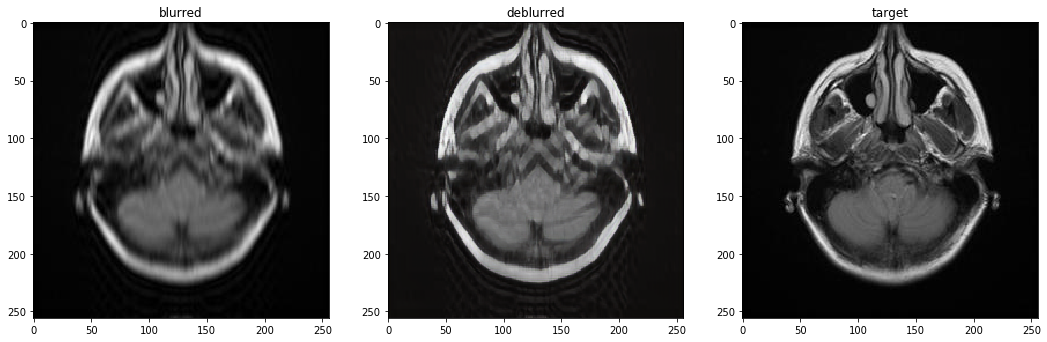

In [28]:
display_test_results(generated_images)

# Analysis of the Model
# Evaluation Metrics

- PSNR
- SSIM

In [26]:
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def calculate_metrics(img1,img2):
    img_array1 = np.array(img1)
    img_array2 = np.array(img2)
    ssim_value, _ = ssim(img_array1, img_array2, full=True, multichannel=False)
    psnr_value = psnr(img_array1, img_array2)

    return ssim_value, psnr_value

avg_ssim_old = 0
avg_psnr_old = 0
avg_ssim_new = 0
avg_psnr_new = 0
for i in range(1):
    deblurred = Image.open("./deblurred/" + str(i) + ".png").convert('L')
    target = Image.open("./target/" + str(i) + ".png").convert('L')
    blurred = Image.open("./blurred/" + str(i) + ".png").convert('L')
    ssim_result_old, psnr_result_old = calculate_metrics(target,blurred)
    ssim_result_new, psnr_result_new = calculate_metrics(target,deblurred)
    avg_ssim_old = avg_ssim_old + ssim_result_old
    avg_ssim_new = avg_ssim_new + ssim_result_new
    avg_psnr_old = avg_psnr_old + psnr_result_old
    avg_psnr_new = avg_psnr_new + psnr_result_new
avg_ssim_old=avg_ssim_old/20
avg_psnr_old=avg_psnr_old/20
avg_ssim_new=avg_ssim_new/20
avg_psnr_new=avg_psnr_new/20

print("RESULTS")
print("-"*25)
print("Avg SSIM between target and blurred image =",avg_ssim_new)
print("Avg SSIM between target and deblurred image =",avg_ssim_old)
print("-"*25)
print("Avg PSNR between target and blurred image =",avg_psnr_new)
print("Avg PSNR between target and deblurred image =",avg_psnr_old)


RESULTS
-------------------------
Avg SSIM between target and blurred image = 0.0233629009358551
Avg SSIM between target and deblurred image = 0.03885910028705605
-------------------------
Avg PSNR between target and blurred image = 0.9760757083722632
Avg PSNR between target and deblurred image = 1.1516601466059513


# END OF THIS MODEL